# **RandomForrest**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
#tf.compat.v1.disable_v2_behavior()

import gc

2023-05-17 19:35:59.270538: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Not connected to a GPU


In [3]:
# Mount the Drive
path=[]
LOCAL = True
if LOCAL:
    path = './content/'
else:    
    from google.colab import drive
    drive.mount('/content/drive')
    path='/content/drive/MyDrive/Colab Notebooks/content/'

In [4]:
df0 = pd.read_csv(f'{path}/data_homes.csv', low_memory=False)
df1 = pd.read_csv(f'{path}/Assessments_vs_Sales.csv')

# **Prepare data**

In [5]:
# add a KEY to corralate our datasets
df0['KEY'] = df0.PRINT_KEY+df0.SALE_DATE + df0['SALE_PRICE_LOG10'].apply(lambda x: round(10**x)).astype(str)
df1['KEY'] = df1.PRINT_KEY+df1.SALE_DATE + (df1['SALE_PRICE']).apply(lambda x: round(x)).astype(str)

In [6]:
# Add a timestamp to our data
import datetime
df0['SALE_TIMESTAMP'] = df0['SALE_DATE'].apply(pd.to_datetime)
df0['SALE_TIMESTAMP'] =df0['SALE_TIMESTAMP'].apply(datetime.datetime.timestamp)

In [7]:
# Drop our duplicate properties
# We ought to be more careful here because of potential bias

df = df0.copy()

#unique_index = df['KEY'].unique().tolist()
#print(f'Dup Indices: {len(df)-len(unique_index)}')
i = df[df.duplicated(subset=['KEY'])].index

#display(df.loc[df['KEY'].isin(i)][['index', 'SALE_PRICE_LOG10', 'YR_BUILT']])
df1[df1.duplicated(subset=['KEY'])] #no dups
df.loc[df['KEY'].isin(i)].index
print(i)

Index([471, 3329, 3934, 4692, 6132, 6386, 10341, 12032, 13119, 13381], dtype='int64')


In [8]:
df.drop(i, inplace=True) # See Appendix 1. Bias in Data Types
df0.drop(i, inplace=True)
len(df) , len(df0)

(14461, 14461)

In [9]:
def report_missing(df):
    for col in list(df.columns):
        if (df[col].isnull().sum()!=0):
          print(f'{col}: {len(df[col].unique())} (Missing: {df[col].isnull().sum()})')
          if (len(df[col].unique()) <=7):
            print(f'\t{df[col].unique()}')

In [10]:
def clean_df(df):
  df0 = df.copy()

  # DROP List
  drop_list = ['issue_date', 'valuation', 'USED_AS_CD', 'TOTAL_RENT_AREA', 'PRINT_KEY', 'SALE_DATE', 'KEY']
  df0.drop(columns=drop_list, axis=1, inplace=True, errors='ingore')

  # IMPUTE 
  df0['WalkIndex'].fillna(float(df0['WalkIndex'].mode()), inplace = True)
  df0['buildings_300m'].fillna(float(df0['buildings_300m'].mode()), inplace = True)
  df0['FRONT_LOG10'].fillna(float(df0['FRONT_LOG10'].min()), inplace = True)
  df0['DEPTH_LOG10'].fillna(float(df0['DEPTH_LOG10'].min()), inplace = True)
  df0['AREA_PARCEL_RECT_LOG10'].fillna(float(df0['AREA_PARCEL_RECT_LOG10'].min()), inplace = True)
  report_missing(df0)
  return df0
df0 = clean_df(df0)

/tmp/ipykernel_29987/4142016641.py:9: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df0['WalkIndex'].fillna(float(df0['WalkIndex'].mode()), inplace = True)
/tmp/ipykernel_29987/4142016641.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  df0['buildings_300m'].fillna(float(df0['buildings_300m'].mode()), inplace = True)


In [11]:
def prepare(df):
  # Drop
  y = df.SALE_PRICE_LOG10.to_numpy()

  df_ = df.copy()
  df_.drop(columns=['SALE_PRICE_LOG10'], inplace=True, errors='ignore')
  
  X = df_.to_numpy()
  #X= np.expand_dims(X, -1)
  return X, y

In [12]:
from sklearn.model_selection import train_test_split

X, y = prepare(df0)
# again we are splitting our data after normalization... not the best practice!
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #, random_state=42)

# **Model**

In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

#!pip install lime
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings("ignore")

In [14]:
y_train[0]

5.193124598354461

In [15]:
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

GradientBoostingRegressor()

In [16]:
gbr.score(x_test, y_test)

0.7391090165638305

In [17]:
def get_cats(df):
    cats = []
    for col in list(df.columns):
        if (len(df[col].unique()) <=10):
            cats.append(col)
    return cats

categorical_features = get_cats(df0)
feature_names = df0.columns.to_list()
#print(feature_names)

# **Explainer**

In [18]:
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(x_train,
    feature_names=feature_names,
    class_names=['price'],
    categorical_features=categorical_features,
    mode='regression')

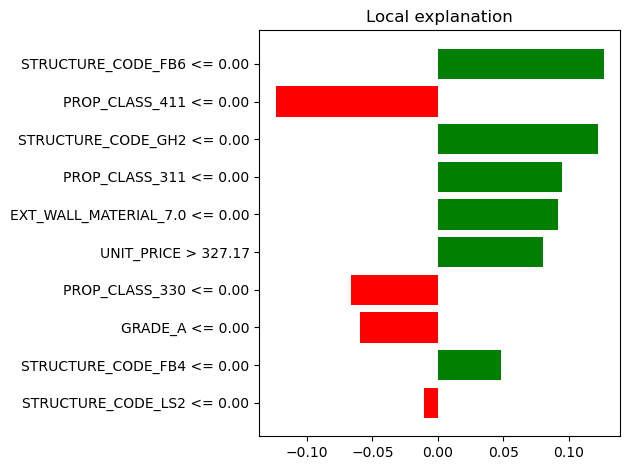

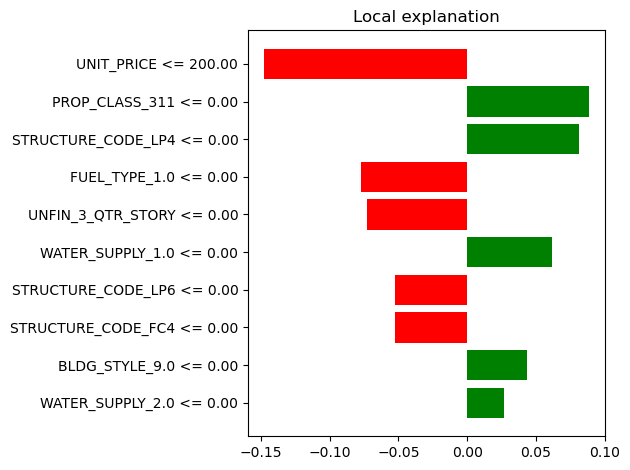

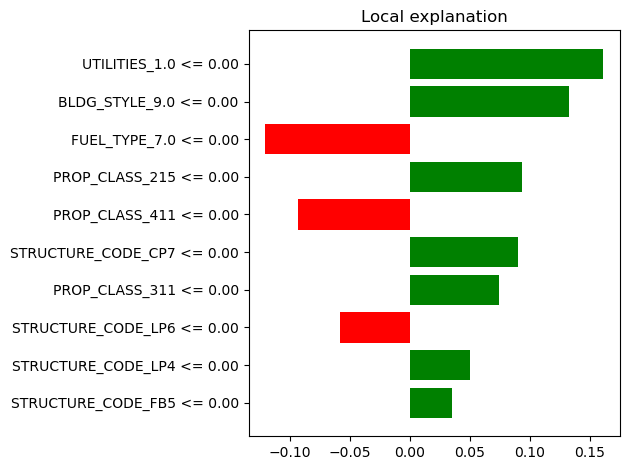

In [20]:
for i in [7, 50, 66]:
    exp = explainer.explain_instance(x_test[i], gbr.predict,
            num_features=10)
    exp.as_pyplot_figure()
    plt.tight_layout()

# **Prediction**

In [21]:
from sklearn.metrics import mean_squared_error
predictions = gbr.predict(x_test)
mean_squared_error(y_test, predictions)

0.012769025179197384

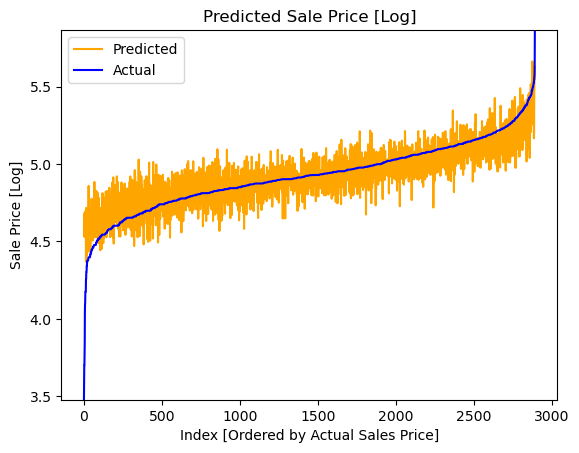

In [22]:
sorted_index = np.argsort(y_test)

yy = []
y_hat = []
mv = []
for i,si in enumerate(sorted_index):
  yy.append(y_test[si])
  y_hat.append(predictions[si])

plt.ylim(y_test.min(),y_test.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.legend();

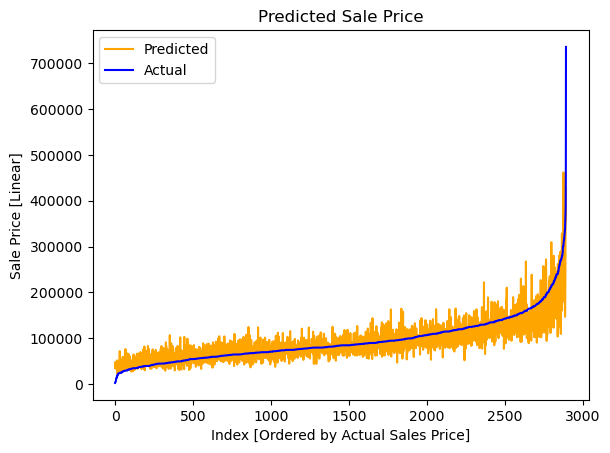

In [23]:
plt.title('Predicted Sale Price')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Linear]')

plt.plot(10**np.array(y_hat),c= 'orange', label='Predicted')
plt.plot(10**np.array(yy), c= 'blue', label='Actual')
plt.legend();

In [24]:
# Recall our correlated indices...
my_index = df['KEY'].to_list()
my_index = df1.loc[df1['KEY'].isin(my_index)]['KEY'].to_list()
df0_ = df.loc[df['KEY'].isin(my_index)]
df1_ = df1.loc[df1['KEY'].isin(my_index)]
len(my_index)

7109

In [25]:
df_new = clean_df(df0_)
X, y = prepare(df_new)

In [26]:
y_hat = gbr.predict(X) 
y_assess = df1_['MARKET_VAL'].apply(np.log10).to_numpy()

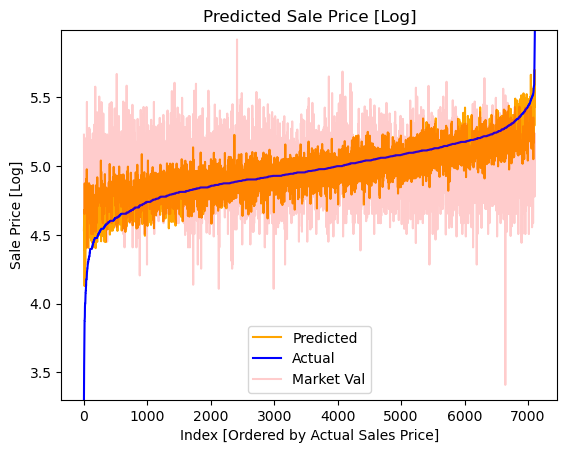

In [27]:
# plot a comparison
sorted_index = np.argsort(y) # sort by actual

yy = []
yy_hat = []
yy_assess = []
for i,si in enumerate(sorted_index):
  yy.append(y[si])
  yy_hat.append(y_hat[si])
  yy_assess.append(y_assess[si])

plt.ylim(y.min(),y.max())

plt.title('Predicted Sale Price [Log]')
plt.xlabel('Index [Ordered by Actual Sales Price]')
plt.ylabel('Sale Price [Log]')

plt.plot(np.array(yy_hat),c= 'orange', label='Predicted')
plt.plot(np.array(yy), c= 'blue', label='Actual')
plt.plot(np.array(yy_assess), c= 'red', label='Market Val',alpha=0.2)
plt.legend();